In [1]:
import os
import shutil

os.chdir('/Users/m193-hb/PycharmProjects/oppUCIDeepLearning/opportunityUCI-DeepLearning/phase1')

if os.path.exists('logs'):
    for item in os.listdir('logs'):
        shutil.rmtree('logs/' + item)

starting...
x_train shape =  (700165, 77)
y_train shape = (700165,)
Some useful info to get an insight on dataset's shape and normalisation:
features shape, labels shape, each features mean, each features standard deviation
(120516, 77) (120516,) -0.025180602413949066 0.6998221188698709
x_test shape = (120516, 77)
y_test shape = (120516,)
the dataset is therefore properly normalised, as expected.
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
segmenting signal...
signal segmented.
train_x shape = (63650, 23, 77)
train_y shape = (63650,)
test_x shape = (10955, 23, 77)
test_y shape = (10955,)
unique test_y [0 1]
unique train_y [0 1]
test_y[1]= [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
train_y shape(1-hot) = (63650, 18)
test_y shape(1-hot) = (10955, 18)
opportunity dataset
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softma

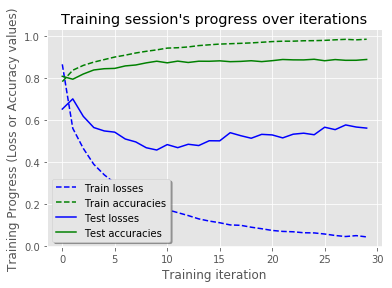

confusion_matrix: /n [[8560   27   15   36   31   44   25   32   15   21   26   10    7   21
    12    8  141   20]
 [  10   58    1   13    0    2    0    0    1    0    0    0    0    0
     0    0    0    0]
 [  10    0   70    1   24    0    0    0    0    0    0    0    0    0
     0    0    0    3]
 [  17    5    0   48    0    0    0    0    0    0    0    0    0    0
     1    0    0    0]
 [   2    0    4    0   92    0    0    0    0    0    0    1    0    0
     0    0    0    0]
 [  35    0    1    0    0  177   16   10    3    1    1    0    1    0
     0    0    2    2]
 [  32    0    0    0    0   16  105    1    6    0    2    1    1    0
     1    0    1    3]
 [  20    0    0    0    0    5    1   78    3    2    0    0    0    2
     3    0    8    2]
 [  32    0    0    1    0    0    1    5   40    2    2    0    7    3
     8    0    0    3]
 [   8    0    0    0    0    1    0    3    1   20    3    2    0    1
     0    0    0    6]
 [   8    0    0    0    0   

In [3]:
import tensorflow as tf
from tensorflow.contrib import rnn
import numpy as np
import pandas as pd
from scipy import stats
import time
from sklearn import metrics
import h5py
import os
import sys
import matplotlib.pyplot as plt

plt.style.use('ggplot')

def windowz(data, size):
    start = 0
    while start < len(data):
        yield start, start + size
        start += (size / 2)
        start = int(start)

def segment_opp(x_train,y_train,window_size):
    segments = np.zeros(((len(x_train)//(window_size//2))-1,window_size,77))
    labels = np.zeros(((len(y_train)//(window_size//2))-1))
    i_segment = 0
    i_label = 0
    for (start,end) in windowz(x_train,window_size):
        if(len(x_train[start:end]) == window_size):
            m = stats.mode(y_train[start:end])
            segments[i_segment] = x_train[start:end]
            labels[i_label] = m[0]
            i_label+=1
            i_segment+=1
    return segments, labels

print("starting...")
start_time = time.time()

# DATA PREPROCESSING

# we start by reading the hdf5 files to a x_train variable, and return the segments to a train_x variable
# this applies for the test and validate sets as well.

if len(sys.argv)<2:
    print("Correct use:python script.py <valid_dataset>")
    sys.exit()


dataset = 'opp'
if dataset == "opp":
    path = os.path.join(os.path.expanduser('~'), 
                        '/Users/m193-hb/PycharmProjects/oppUCIDeepLearning/opportunityUCI-DeepLearning/phase1', 
                        'opportunity.h5')
else:
    print("Dataset not supported yet")
    sys.exit()

f = h5py.File(path, 'r')


x_train = f.get('train').get('inputs')[()]
y_train = f.get('train').get('targets')[()]
x_test = f.get('test').get('inputs')[()]
y_test = f.get('test').get('targets')[()]

print("x_train shape = ", x_train.shape)
print("y_train shape =",y_train.shape)
print("Some useful info to get an insight on dataset's shape and normalisation:")
print("features shape, labels shape, each features mean, each features standard deviation")
print(x_test.shape, y_test.shape, np.mean(x_test), np.std(x_test))
print("x_test shape =" ,x_test.shape)
print("y_test shape =",y_test.shape)
print("the dataset is therefore properly normalised, as expected.")

#unique test
print(np.unique(y_train))
print(np.unique(y_test))
unq = np.unique(y_test)

input_width = 23
if dataset == "opp":
    input_width = 23
    print("segmenting signal...")
    train_x, train_y = segment_opp(x_train,y_train,input_width)
    test_x, test_y = segment_opp(x_test,y_test,input_width)
    print("signal segmented.")
else:
    print("no correct dataset")
    exit(0)

print("train_x shape =",train_x.shape)
print("train_y shape =",train_y.shape)
print("test_x shape =",test_x.shape)
print("test_y shape =",test_y.shape)

# One-hot label conversion
train = pd.get_dummies(train_y)
test = pd.get_dummies(test_y)

train, test = train.align(test, join='inner', axis=1) # maybe 'outer' is better

train_y = np.asarray(train)
test_y = np.asarray(test)


print("unique test_y",np.unique(test_y))
print("unique train_y",np.unique(train_y))
print("test_y[1]=",test_y[1])
print("train_y shape(1-hot) =",train_y.shape)
print("test_y shape(1-hot) =",test_y.shape)

# DEFINING THE MODEL
if dataset=="opp":
    print("opportunity dataset")
    input_height = 1
    input_width = input_width #or 90 for actitracker
    num_labels = 18  #or 6 for actitracker
    num_channels = 77 #or 3 for actitracker
else:
    print("wrong dataset")


learning_rate = 0.001
training_iters = 100000
batch_size = 64
display_step = 10



# Network Parameters
n_input = num_channels # MNIST data input (img shape: 28*28)
n_steps = input_width # timesteps
n_hidden = 128 # hidden layer num of features
n_classes = num_labels # MNIST total classes (0-9 digits)


# tf Graph input
# n_steps == window_size ||||  n_input == features 
x = tf.placeholder("float", [None, n_steps, n_input])
y = tf.placeholder("float", [None, n_classes])

# Define weights
weights = {
    # Hidden layer weights => 2*n_hidden because of forward + backward cells
    'out': tf.Variable(tf.random_normal([2*n_hidden, n_classes]))
}
biases = {
    'out': tf.Variable(tf.random_normal([n_classes]))
}


def BiRNN(x, weights, biases):

    x = tf.unstack(x, n_steps, 1)

    lstm_fw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=0.5)
    # Backward direction cell
    lstm_bw_cell = rnn.BasicLSTMCell(n_hidden, forget_bias=0.5)

    # Get lstm cell output
    try:
        outputs, _, _ = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                              dtype=tf.float32)
    except Exception: # Old TensorFlow version only returns outputs not states
        outputs = rnn.static_bidirectional_rnn(lstm_fw_cell, lstm_bw_cell, x,
                                        dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(outputs[-1], weights['out']) + biases['out']

pred = BiRNN(x, weights, biases)

# Define loss and optimizer
with tf.name_scope('loss'):
    cost = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))  # + l2
tf.summary.scalar('loss', cost)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(cost)

# optimizer = tf.train.AdagradOptimizer(learning_rate=learning_rate).minimize(cost)

# optimizer = tf.train.AdadeltaOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model


with tf.name_scope('accuracy'):
    with tf.name_scope('correct_prediction'):
        correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
    with tf.name_scope('accuracy'):
        accuracy = tf.reduce_mean(tf.cast(correct_pred, dtype=tf.float32))
tf.summary.scalar('accuracy', accuracy)

merged = tf.summary.merge_all()

training_epochs = 30
loss_over_time_train = np.zeros(training_epochs)
accuracy_over_time_train = np.zeros(training_epochs)
loss_over_time_test = np.zeros(training_epochs)
accuracy_over_time_test = np.zeros(training_epochs)
total_batches = train_x.shape[0] // batch_size
best_accuracy = 0.0
# Launch the graph
with tf.Session() as sess:
    # Init summary
    train_writer = tf.summary.FileWriter('logs/train', sess.graph)
    test_writer = tf.summary.FileWriter('logs/test')
    # sess.run(init)
    tf.initialize_all_variables().run()
    # Keep training until reach max iterations
    # cost_history = np.empty(shape=[0],dtype=float)
    i = 0
    for epoch in range(training_epochs):
        cost_history_train = np.empty(shape=[0],dtype=float)
        accuracy_history_train = np.empty(shape=[0],dtype=float)
        cost_history_test = np.empty(shape=[0],dtype=float)
        accuracy_history_test = np.empty(shape=[0],dtype=float)
        for step in range(total_batches):
            offset = (step * batch_size) % (train_y.shape[0] - batch_size)
            batch_x = train_x[offset:(offset + batch_size), :, :]
            batch_y = train_y[offset:(offset + batch_size), :]

            # print("batch_x shape =",batch_x.shape
            # print("batch_y shape =",batch_y.shape

            train_summary, _, c, acc = sess.run([merged, optimizer, cost, accuracy],feed_dict={x: batch_x, y : batch_y})
            # Add into train_writer, view in tensorboard
            train_writer.add_summary(train_summary, i)
            
            cost_history_train = np.append(cost_history_train,c)
            accuracy_history_train = np.append(accuracy_history_train, acc)
            i += 1
        loss_over_time_train[epoch] = np.mean(cost_history_train)
        accuracy_over_time_train[epoch] = np.mean(accuracy_history_train)

        print("Epoch: {},".format(epoch) +
              "Train accuracy : {},".format(accuracy_over_time_train[epoch]) +
              "Train Loss : {}".format(loss_over_time_train[epoch]))
        # after every epoch, we test the model with the test data
        test_summary, pred_out, accuracy_out, loss_out = sess.run([merged, pred, accuracy, cost], feed_dict={x: test_x, y: test_y})
        loss_over_time_test[epoch] = loss_out
        accuracy_over_time_test[epoch] = accuracy_out
        best_accuracy = max(best_accuracy, accuracy_out)
        print("Training iter: {},".format(epoch) +
              "Test accuracy : {},".format(accuracy_out) +
              "Loss : {}".format(loss_out))
        best_accuracy = max(best_accuracy, accuracy_out)
        # Add into test_writer, view in tensorboard
        test_writer.add_summary(test_summary, i)

        # Save the info into a file
        # merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter('logs/')

    print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_x, y: test_y}))
    print("Final test accuracy: {}".format(accuracy_out))

    # MORE METRICS
    print("Best epoch's test accuracy: {}".format(best_accuracy))
    # pred is the result of the BD-RNN
    y_p = tf.argmax(pred, 1)
    val_accuracy, y_pred = sess.run([accuracy, y_p], feed_dict={x:test_x, y:test_y})
    y_true = np.argmax(test_y,1)

    if dataset=="opp":
        print("f1_score_mean", metrics.f1_score(y_true, y_pred, average="micro"))
        print("f1_score_weighted", metrics.f1_score(y_true, y_pred, average="weighted"))
        print("f1_score_macro", metrics.f1_score(y_true, y_pred, average="macro"))
        # print("f1_score_per_class", metrics.f1_score(y_true, y_pred, average=None)
    else:
        print("wrong dataset")

    plt.figure(1)
    # indep_train_axis = np.array(range(batch_size, (len(loss_over_time_train)+1)*batch_size, batch_size))
    plt.plot(loss_over_time_train, "b--", label="Train losses")
    plt.plot(accuracy_over_time_train, "g--", label="Train accuracies")
    # indep_test_axis = np.array(range(batch_size, (len(loss_over_time_test)+1)*batch_size, batch_size))
    plt.plot(loss_over_time_test, "b-", label="Test losses")
    plt.plot(accuracy_over_time_test, "g-", label="Test accuracies")

    plt.title("Training session's progress over iterations")
    plt.legend(shadow=True)
    plt.ylabel('Training Progress (Loss or Accuracy values)')
    plt.xlabel('Training iteration')

    plt.show()

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)
    print("confusion_matrix: /n", confusion_matrix)
    normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32) / np.sum(confusion_matrix) * 100
    print("")
    print("Confusion matrix (normalised to % of total test data):")
    print(normalised_confusion_matrix)
    print("Note: training and testing data is not equally distributed amongst classes, ")
    with open('out_bdlstm.txt', 'w') as f:
        # print >> f, 'Filename:', confusion_matrix
        print('Confusion Matrix:', confusion_matrix, file=f)
        print('Normalised Confusion Matrix:', normalised_confusion_matrix, file=f)

    #######################################################################################
    #### micro- macro- weighted explanation ###############################################
    #                                                                                     #
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html      #
    #                                                                                     #
    # micro :Calculate metrics globally by counting the total true positives,             #
    # false negatives and false positives.                                                #
    #                                                                                     #
    # macro :Calculate metrics for each label, and find their unweighted mean.            #
    # This does not take label imbalance into account.                                    #
    #                                                                                     #
    # weighted :Calculate metrics for each label, and find their average, weighted        #
    # by support (the number of true instances for each label). This alters macro         #
    # to account for label imbalance; it can result in an F-score that is not between     #
    # precision and recall.                                                               #
    #                                                                                     #
    #######################################################################################

print("--- %s seconds ---" % (time.time() - start_time))
print("Bi-directional LSTM Opportunity Done")